Found 1280 images belonging to 4 classes.
Found 319 images belonging to 4 classes.
Found 378 images belonging to 4 classes.


C:\Users\ASUS\fyp\django-lms\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100


C:\Users\ASUS\fyp\django-lms\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
C:\Users\ASUS\fyp\django-lms\venv\Lib\site-packages\PIL\Image.py:979: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3553 - loss: 5.2268
Epoch 1: val_accuracy improved from -inf to 0.25078, saving model to best_model.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.3578 - loss: 5.2194 - val_accuracy: 0.2508 - val_loss: 4.8256 - learning_rate: 1.0000e-04
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4947 - loss: 4.7976
Epoch 2: val_accuracy did not improve from 0.25078
20/20 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.4944 - loss: 4.7980 - val_accuracy: 0.2508 - val_loss: 5.7269 - learning_rate: 1.0000e-04
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5239 - loss: 4.6162
Epoch 3: val_accuracy did not improve from 0.25078
20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.5234 - loss: 4.6162 - val_accuracy: 0.2508 - val_loss: 7.1772 - learning_rate: 1.0000e-04
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5712 - loss: 4.5305
Epoch 4: val_accuracy did not improve from 0.25078
20/20 ━━

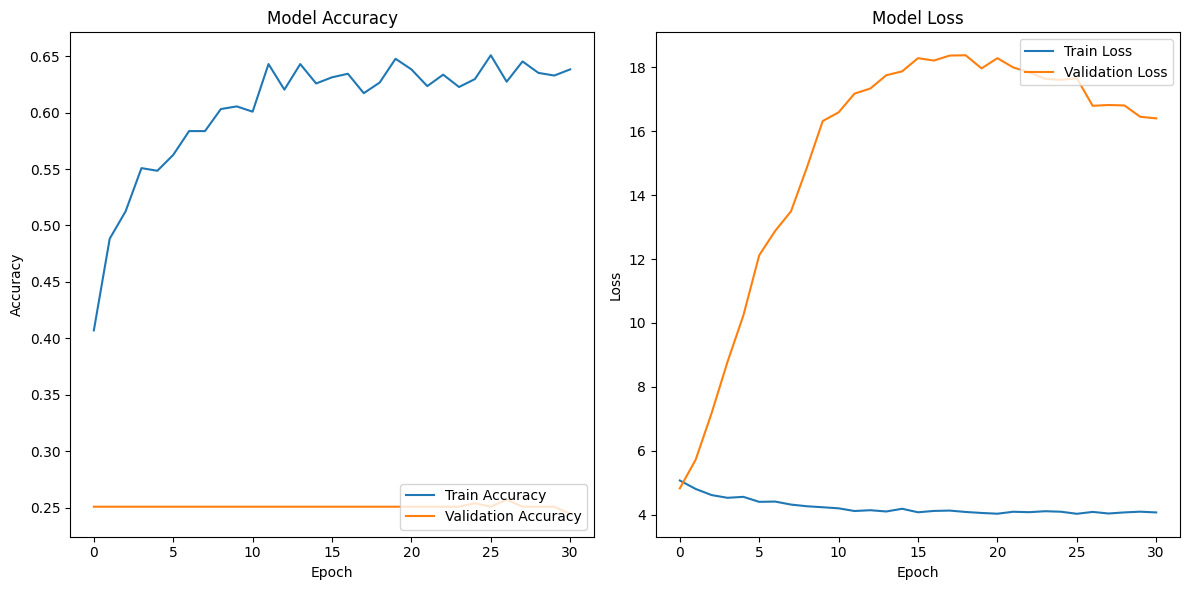

In [1]:
# Import necessary libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import os
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight

# Define the path to your dataset folders
base_dir = r'C:\Users\ASUS\OneDrive\Desktop\fyp2\datasets\apple_disease_classification'
train_dir = os.path.join(base_dir, 'Train')
test_dir = os.path.join(base_dir, 'Test')

# Image augmentation for the training set with validation split
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

# No augmentation for the test set, just rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# Load the training data with validation split
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=64,  # Increased batch size
    class_mode='categorical',
    subset='training'
)

# Load the validation data
val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=64,
    class_mode='categorical',
    subset='validation'
)

# Load the test data
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=64,
    class_mode='categorical'
)

# EarlyStopping callback to stop training when the validation loss stops improving
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=30,
    restore_best_weights=True,
    verbose=1
)

# ModelCheckpoint callback to save the best model based on validation accuracy
model_checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# ReduceLROnPlateau callback to reduce learning rate on plateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=10,
    min_lr=1e-7,
    verbose=1
)

# Create the model with L2 regularization and reduced complexity
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', kernel_regularizer=l2(0.01), input_shape=(150, 150, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.4),

    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

# Compile the model with a reduced learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Calculate class weights
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(train_generator.classes),
                                     y=train_generator.classes)
class_weights = dict(enumerate(class_weights))

# Train the model
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=val_generator,
    callbacks=[early_stopping, model_checkpoint, reduce_lr],
    class_weight=class_weights
)

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# Show plots
plt.tight_layout()
plt.show()
